In [2]:
import numpy as np
import pandas as pd
import time

## Reading Features

In [3]:
#PRS = np.load('PRS.npy')
FE = np.load('FE.npy')
labels = np.load('LOS.npy')
#cor = np.load('cor.npy')
#RX = np.load('RX_time.npy')
#RX = np.stack((np.abs(RX), np.angle(RX)), axis = -2)
#print(f'RX shape = {RX.shape}\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')

statistical feature shape = (7102, 5, 6),
LOS/NLOS labels = (array([0, 1]), array([6677,  425]))


In [4]:
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preprocessing Data
### Investigating transformation for dimention reduction
Dimention reduction techniques are usually based on eigen value and eigen vector decomposition. By doing this analysis, we can find that if lower numebr of features are able to explain feature variances or not. If so, a linear or non-linear dimenionality reduction technique such as PCA or LDA can be considered. 

In addition, the initial train/test split is build in this section. other preprocessing requirements sucha as scaling the data will be performed inside the pipelines

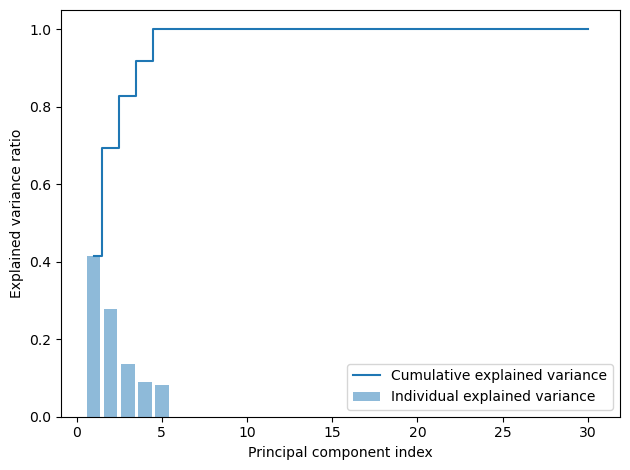

In [5]:
X = FE.reshape(FE.shape[0], -1)
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

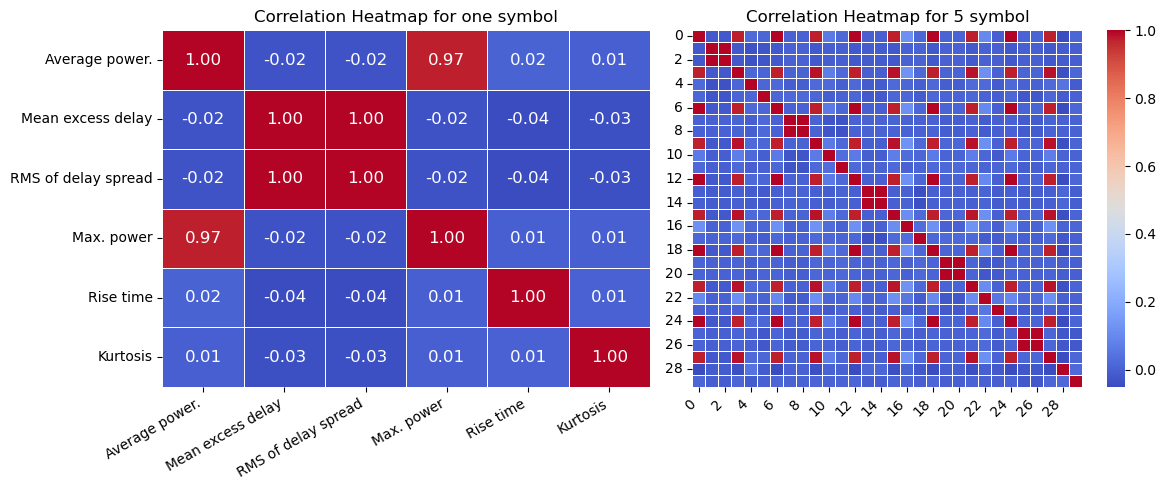

In [6]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X[:,:], rowvar=False)
correlation_labels = ["Average power.", "Mean excess delay", "RMS of delay spread", "Max. power", "Rise time", "Kurtosis"]
# Create a heatmap to visualize the correlation matrix

# Create a mask to display only half of the correlation matrix

# Create a heatmap to visualize the correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(correlation_matrix[:6,:6], annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=False, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[0])
axes[0].set_xticklabels(correlation_labels, rotation=30, horizontalalignment='right')
axes[0].set_yticklabels(correlation_labels, rotation=0, va='center')  # Set custom y-axis labels
axes[0].set_title('Correlation Heatmap for one symbol')

sns.heatmap(correlation_matrix[:,:], annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=True, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, va='center')  # Set custom y-axis labels if needed
axes[1].set_title('Correlation Heatmap for 5 symbol')

plt.tight_layout()
plt.show()

In [7]:
ind = np.array([0, 1, 4, 5, 0+6, 1+6, 4+6, 5+6, 0+12, 1+12, 4+12, 5+12, 0+18, 1+18, 4+18, 5+18, 0+24, 1+24, 4+24, 5+24])
XX = X[:,ind]
XX.shape

(7102, 20)

In [8]:
# Remove correlated statistical features (Even coulmns)
df = pd.DataFrame(XX)
df.columns
df.iloc[:,:8].describe()

,0,1,2,3,4,5,6,7
count,7102.000000,7102.000000,7102.000000,7.102000e+03,7102.000000,7102.000000,7102.000000,7.102000e+03
mean,0.000012,0.017058,8.331390,1.172447e+03,0.000012,0.017058,19.890376,1.172447e+03
std,0.000008,0.000115,20.935302,7.295290e-09,0.000008,0.000114,45.837967,7.521404e-09
min,0.000002,0.016648,-205.454926,1.172447e+03,0.000002,0.016602,-141.047647,1.172447e+03
25%,0.000007,0.016982,0.000000,1.172447e+03,0.000007,0.016981,0.000000,1.172447e+03
50%,0.000009,0.017056,0.000000,1.172447e+03,0.000009,0.017058,0.000000,1.172447e+03
75%,0.000013,0.017136,4.730410,1.172447e+03,0.000013,0.017135,8.098704,1.172447e+03
max,0.000064,0.017475,276.589569,1.172447e+03,0.000064,0.017538,403.140930,1.172447e+03


## Naive Random serach for best pipeline
In this section, we are looking for an initial architecture with a proper performance in terms of accuracy and roc-auc to use it as a baseline for learning transformer hyper parameters. To do so, a RandomizedSearch with 10 fold stratified cross validation is used. 
[Cross validation procedure to avoid overfitting](https://scikit-learn.org/stable/_images/grid_search_workflow.png) <br> <br>
<div style="text-align:center;">
<a href="https://scikit-learn.org">
    <img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500" height="300">
</a>
</div>



In [9]:
X_train, X_test, y_train, y_test = train_test_split(XX, labels, test_size=0.2, random_state=42, stratify=labels)

In [25]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
}

transformers = {
    'PCA': PCA(n_components=None),  
    'KernelPCA': KernelPCA(n_components=None),  
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'TruncatedSVD': TruncatedSVD()

}

estimators = {
    #classic estimators
    'LogisticRegression': LogisticRegression(max_iter=200),
    'SVM': SVC(probability=True),
    'SGD': SGDClassifier(loss = 'log_loss'),
    'KNN': KNeighborsClassifier(),
    #'RadiusNeighbhborsClassifier': RadiusNeighborsClassifier(),
    'NaiveBayes': GaussianNB(), 
    #boosting / ensemble estimators 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    #Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000, random_state=42), 
}
param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
    }

pipeline = Pipeline([
    ('scaler', None),
    ('transformer', None),
    ('estimator', None)
])

n_splits = 10
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scoring = {"AUC": "roc_auc", 'f1': 'f1'}
#random_search = RandomizedSearchCV(
#    estimator=pipeline,
#    param_distributions = param_grids,
#    n_iter = 10,
#    cv = stratified_kf,
#    n_jobs = -1,
#    verbose = 1,
#    random_state = 2561,
#    scoring = scoring,
#    refit= 'AUC'
#)
#random_search.fit(X_train, y_train)

search = GridSearchCV(estimator = pipeline, param_grid = param_grids, cv = 5, n_jobs = -1, verbose = 1, scoring = scoring, refit= 'AUC', return_train_score=True)
search.fit(X_train, y_train)

# Get the best parameters for each step
#best_scaler = random_search.best_params_['scaler']
#best_transformer = random_search.best_params_['transformer']
#best_estimator = random_search.best_params_['estimator']
# Now you can use the best parameters to construct the final pipeline
#final_pipeline = Pipeline([
#    ('scaler', best_scaler),
#    ('transformer', best_transformer),
#    ('estimator', best_estimator)
#])
# Fit the final pipeline to the training data
#final_pipeline.fit(X_train, y_train)
#final_pipeline

Fitting 5 folds for each of 176 candidates, totalling 880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None), ('transformer', None),
                                       ('estimator', None)]),
             n_jobs=-1,
             param_grid={'estimator': [LogisticRegression(max_iter=200),
                                       SVC(probability=True),
                                       SGDClassifier(loss='log_loss'),
                                       KNeighborsClassifier(), GaussianNB(),
                                       DecisionTreeClassifier(),
                                       RandomForestClassifier(),
                                       GradientBoostingClassifier(),
                                       ExtraTreesClassifier(),
                                       AdaBoostClassifier(),
                                       MLPClassifier(hidden_layer_sizes=(50, 50,
                                                                         50),
                                                     max_iter=1000,
                                                     random_state=42)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler(), Normalizer()],
                         'transformer': [PCA(), KernelPCA(),
                                         LinearDiscriminantAnalysis(),
                                         TruncatedSVD()]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'f1': 'f1'}, verbose=1)

In [26]:
print(search.cv_results_.keys())
scores = search.cv_results_['rank_test_AUC']
param_sets = search.cv_results_['params']

# Find the indices that would sort the scores in descending order
sorted_indices = np.argsort(scores)
#Get the 5 best parameter sets and their corresponding scores
best_param_sets = [param_sets[i] for i in sorted_indices[:50]]
best_scores = [scores[i] for i in sorted_indices[:50]]
# Print the best parameter sets and scores
for i, (params, score) in enumerate(zip(best_param_sets, best_scores)):
    print(f"Rank {i + 1}: Parameters: {params}, Rank (based on AUC test): {score:.0f}")


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator', 'param_scaler', 'param_transformer', 'params', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1', 'split2_train_f1', 'split3_train_f1', 'split4_train_f1', 'mean_train_f1', 'std_train_f1'])
Rank 1: Parameters: {'estimator': LogisticRegression(max_iter=200), 'scaler': RobustScaler(), 'transformer': PCA()}, Rank (based on AUC test): 1
Rank 2: Parameters: {'estimator': LogisticRegression(max_iter=200), 'scaler': RobustScaler(), 'transformer': KernelPCA()}, Rank (based on AUC test): 1
Rank 3: Par

In [27]:
unique_classifiers = set()
selected_pipes = []
for item in best_param_sets:
    classifier = item['estimator']
    if classifier not in unique_classifiers:
        unique_classifiers.add(classifier)
        selected_pipes.append(item)

top_pipelines = [Pipeline([
    ('scaler', pipe['scaler']),
    ('transformer', pipe['transformer']),
    ('estimator', pipe['estimator'])
]) for pipe in selected_pipes]
top_pipelines

[Pipeline(steps=[('scaler', RobustScaler()), ('transformer', PCA()),
                 ('estimator', LogisticRegression(max_iter=200))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', KernelPCA()),
                 ('estimator', SGDClassifier(loss='log_loss'))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),
                 ('estimator',
                  MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000,
                                random_state=42))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),
                 ('estimator', SVC(probability=True))]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', PCA()),
                 ('estimator', GradientBoostingClassifier())]),
 Pipeline(steps=[('scaler', StandardScaler()), ('transformer', KernelPCA()),
                 ('estimator', ExtraTreesClassifier())]),
 Pipeline(steps=[('scaler', MinMaxScaler()), ('transformer', TruncatedSVD()),

In [28]:
estimator_params = {
    'LogisticRegression': {
        'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        #'estimator__solver': ['lbfgs', 'liblinear'],
        #'estimator__max_iter': [100, 200, 500, 1000],
    },
    'SGDClassifier': {
        'estimator__loss': ['modified_huber'],
        'estimator__alpha': [0.001, 0.01, 0.1, 0.2],
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        #'estimator__max_iter': [int(np.ceil(10**6 / X_train.shape[0]))],
        #'estimator__penalty': ['l2', 'l1', 'elasticnet'],
        #'estimator__learning_rate': ['optimal', 'adaptive'],
    },
    'MLPClassifier': {
        'estimator__hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
        'estimator__alpha': [0.0001, 0.001, 0.01],
        'estimator__learning_rate_init': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        #'estimator__kernel': ['linear', 'rbf', 'sigmoid'],
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__C': [0.1, 1, 10],
        'estimator__gamma': [0.1, 1, 'scale', 'auto'],
    },
    'ExtraTreesClassifier': {
        'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'estimator__max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
        #'estimator__min_samples_leaf': [1, 2, 4], 
        #'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for the best split # Minimum number of samples required to be at a leaf node
        },
    'GradientBoostingClassifier': {
        'estimator__n_estimators': [50, 100, 150], 
        'estimator__learning_rate': [0.01, 0.1],
        #'estimator__max_depth': [3, 4 ,5],
        #'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        #'estimator__min_samples_leaf': [2, 4, 6],  # Minimum number of samples required to be at a leaf node
        },
    'AdaBoostClassifier': {
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__n_estimators': [50, 100, 200], 
        'estimator__learning_rate': [0.01, 0.1, 0.2],          # Minimum samples required to split a node
        'estimator__estimator': [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4), RandomForestClassifier(n_estimators=50), RandomForestClassifier(n_estimators=100) ],            # Minimum samples required at each leaf node
        },
    'GaussianNB': {
        'estimator__var_smoothing': [1e-9, 1e-7, 1e-5]
        },
    'RandomForestClassifier': {
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__n_estimators': [50, 100, 200], 
        'estimator__max_depth': [None, 10, 20, 30],
        'estimator__min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
        'estimator__min_samples_leaf': [2, 4, 8],            # Minimum samples required at each leaf node
        #'estimator__max_features': [None, 'sqrt', 'log2'],  # Number of features to consider for the best split
        #'estimator__criterion': ['gini', 'entropy'],
        },
    }

### Grid search for best hyper parameters of each top pipeline

In [29]:
#Hyper parameter tunning of top pipeline through a new grid search
est_times = []
est_names = []
est_f1 = []
est_AUC = []
est_accuracy = []
results = {}
for pipeline in top_pipelines:
    est_name = pipeline.named_steps['estimator'].__class__.__name__
    start_time = time.time()
    gs = GridSearchCV(estimator=pipeline, 
                  param_grid = estimator_params[est_name], 
                  scoring = {'Accuracy': 'accuracy', "AUC": "roc_auc", 'f1': 'f1'},
                  refit= 'AUC',
                  cv = stratified_kf,
                  n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    est_times.append(elapsed_time)
    est_names.append(est_name)
    best_AUC = gs.best_score_
    est_AUC.append(best_AUC)
    print(f'estimator: {est_name}')
    print(f'best AUC score: {best_AUC}')
    print(f'best params: {gs.best_params_}')
    print(f'elapsed time: {elapsed_time:.2f} second')
    pipeline.set_params(**gs.best_params_)
    best_f1 = max(gs.cv_results_['mean_test_f1'])
    best_acc = max(gs.cv_results_['mean_test_Accuracy']) 
    est_f1.append(best_f1)
    est_accuracy.append(best_acc)
    results[est_name] = gs.cv_results_

estimator: LogisticRegression
best AUC score: 0.9649663765537717
best params: {'estimator__C': 1.0, 'estimator__class_weight': None}
elapsed time: 1.32 second
estimator: SGDClassifier
best AUC score: 0.9646416004183884
best params: {'estimator__alpha': 0.001, 'estimator__loss': 'modified_huber'}
elapsed time: 296.57 second
estimator: MLPClassifier
best AUC score: 0.9640967482235989
best params: {'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (50, 100, 50), 'estimator__learning_rate_init': 0.001}
elapsed time: 127.22 second
estimator: SVC
best AUC score: 0.9641737650641483
best params: {'estimator__C': 10, 'estimator__gamma': 0.1}
elapsed time: 12.03 second
estimator: GradientBoostingClassifier
best AUC score: 0.9600868897385689
best params: {'estimator__learning_rate': 0.01, 'estimator__n_estimators': 150}
elapsed time: 31.00 second
estimator: ExtraTreesClassifier
best AUC score: 0.9650809649702576
best params: {'estimator__max_depth': 30, 'estimator__min_samples_split': 10

### Comparing Trained Top pipeline performane

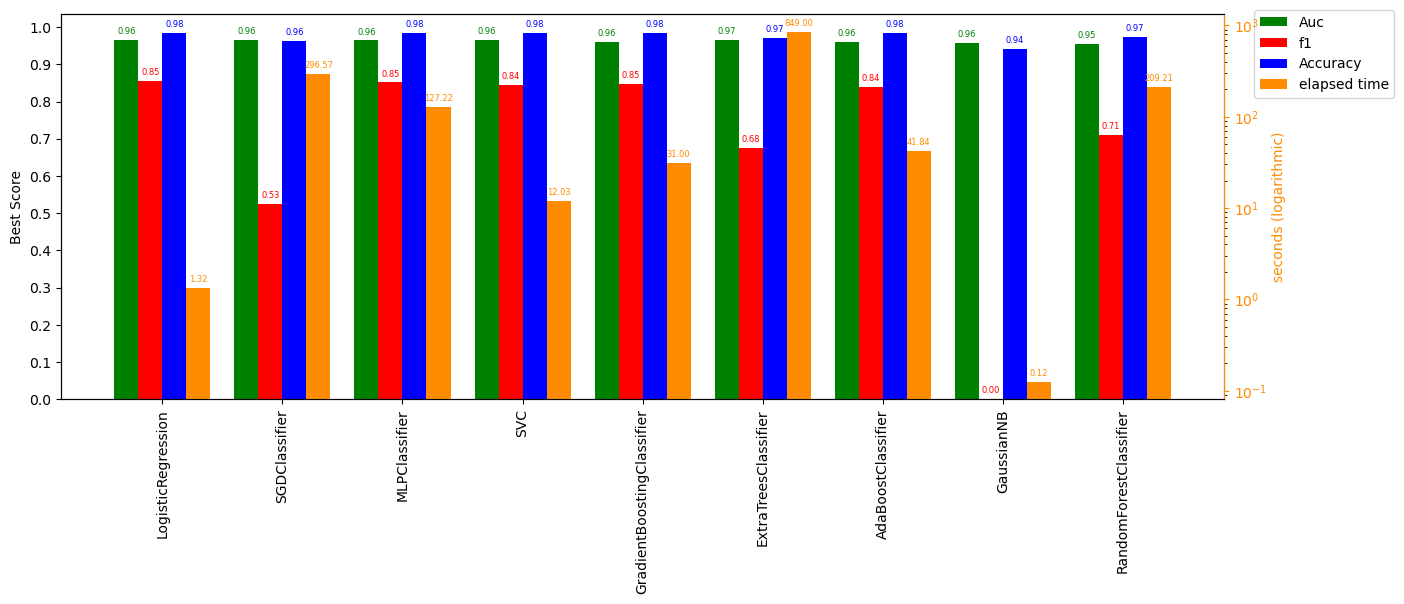

In [53]:
# Sample data

x = np.arange(len(est_names))  # x-axis locations for the bars
width = 0.2  # Width of the bars

# Create the bar chart for the first dataset
fig, ax1 = plt.subplots(figsize=(15, 5))
bar_f1 = ax1.bar(x , est_AUC, width, label='Auc', color = 'g')
bar_f2 = ax1.bar(x+width , est_f1, width, label='f1', color = 'red')
bar_f3 = ax1.bar(x +2*width, est_accuracy, width, label='Accuracy', color = 'blue')
ax1.set_xticks(x+1.5*width, est_names, rotation = 90)
ax1.set_yticks(np.arange(0,1.1,0.1))
ax1.set_ylabel('Best Score')
ax1.bar_label(bar_f1, fmt = '%.2f', label_type='edge', padding=3, color = 'g', fontsize = 6)
ax1.bar_label(bar_f2, fmt = '%.2f', label_type='edge', padding=3, color = 'r', fontsize = 6)
ax1.bar_label(bar_f3, fmt = '%.2f', label_type='edge', padding=3, color = 'b', fontsize = 6)




ax2 = ax1.twinx()
bar_f4 = ax2.bar(x+3*width, est_times, width, label='elapsed time', log = True, color = 'darkorange')
ax2.set_ylabel('seconds (logarithmic)', color = 'darkorange')
ax2.spines['right'].set_color('darkorange')
ax2.yaxis.label.set_color('darkorange')
ax2.tick_params(axis='y', colors='darkorange')
ax2.bar_label(bar_f4, fmt = '%.2f', label_type='edge', padding=3, color = 'darkorange', fontsize = 6)

# Combine legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
combined_labels = labels1 + labels2
ax1.legend(lines1 + lines2, combined_labels, loc='upper left', bbox_to_anchor=(1.02, 1.03), frameon=True)
plt.show()


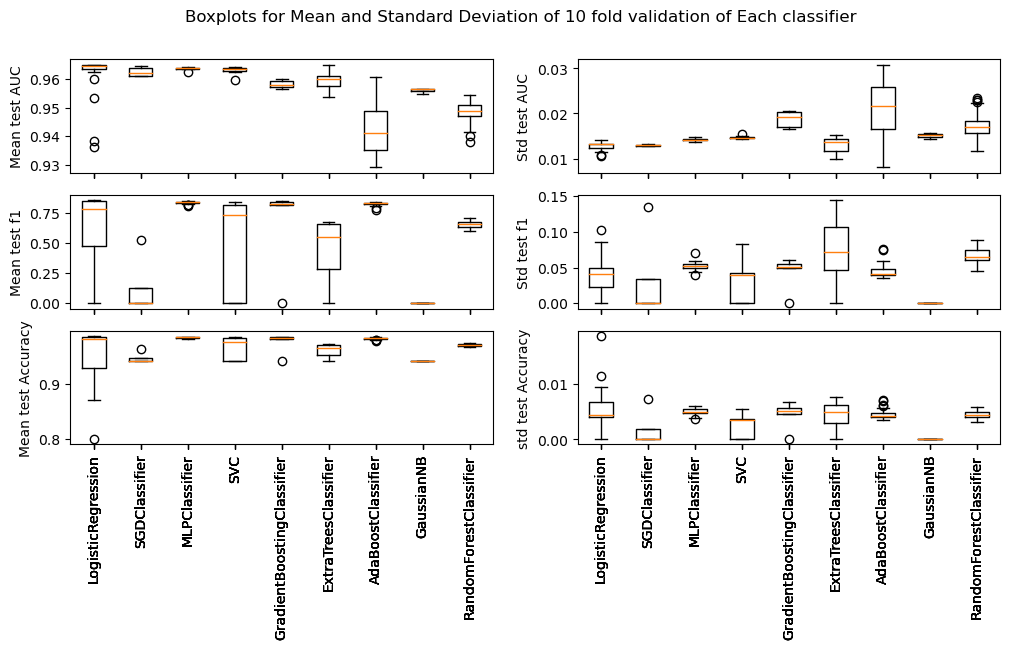

In [38]:
# Create two subplots for 'mean' and 'std'
fig, axs = plt.subplots(3, 2, figsize=(12, 5), sharex=True)
fig.suptitle('Boxplots for Mean and Standard Deviation of 10 fold validation of Each classifier')
# Boxplot for 'mean' values
axs[0][0].boxplot([results[key]['mean_test_AUC'] for key in results.keys()], labels=results.keys())
axs[0][0].set_ylabel('Mean test AUC')
axs[2][0].set_xticklabels(results.keys(), rotation=90)
axs[2][1].set_xticklabels(results.keys(), rotation=90)
# Boxplot for 'std' values
axs[0][1].boxplot([results[key]['std_test_AUC'] for key in results.keys()], labels=results.keys())
axs[0][1].set_ylabel('Std test AUC')
#axs[0][1].set_xticklabels(results.keys(), rotation=90)

axs[1][0].boxplot([results[key]['mean_test_f1'] for key in results.keys()], labels=results.keys())
axs[1][0].set_ylabel('Mean test f1')
#axs[1][0].set_xticklabels(results.keys(), rotation=90)

axs[1][1].boxplot([results[key]['std_test_f1'] for key in results.keys()], labels=results.keys())
axs[1][1].set_ylabel('Std test f1')
#axs[1][1].set_xticklabels(results.keys(), rotation=90)
axs[2][0].boxplot([results[key]['mean_test_Accuracy'] for key in results.keys()], labels=results.keys())
axs[2][0].set_ylabel('Mean test Accuracy')
axs[2][1].boxplot([results[key]['std_test_Accuracy'] for key in results.keys()], labels=results.keys())
axs[2][1].set_ylabel('std test Accuracy')

plt.show()

### Investigating top pipeline performance

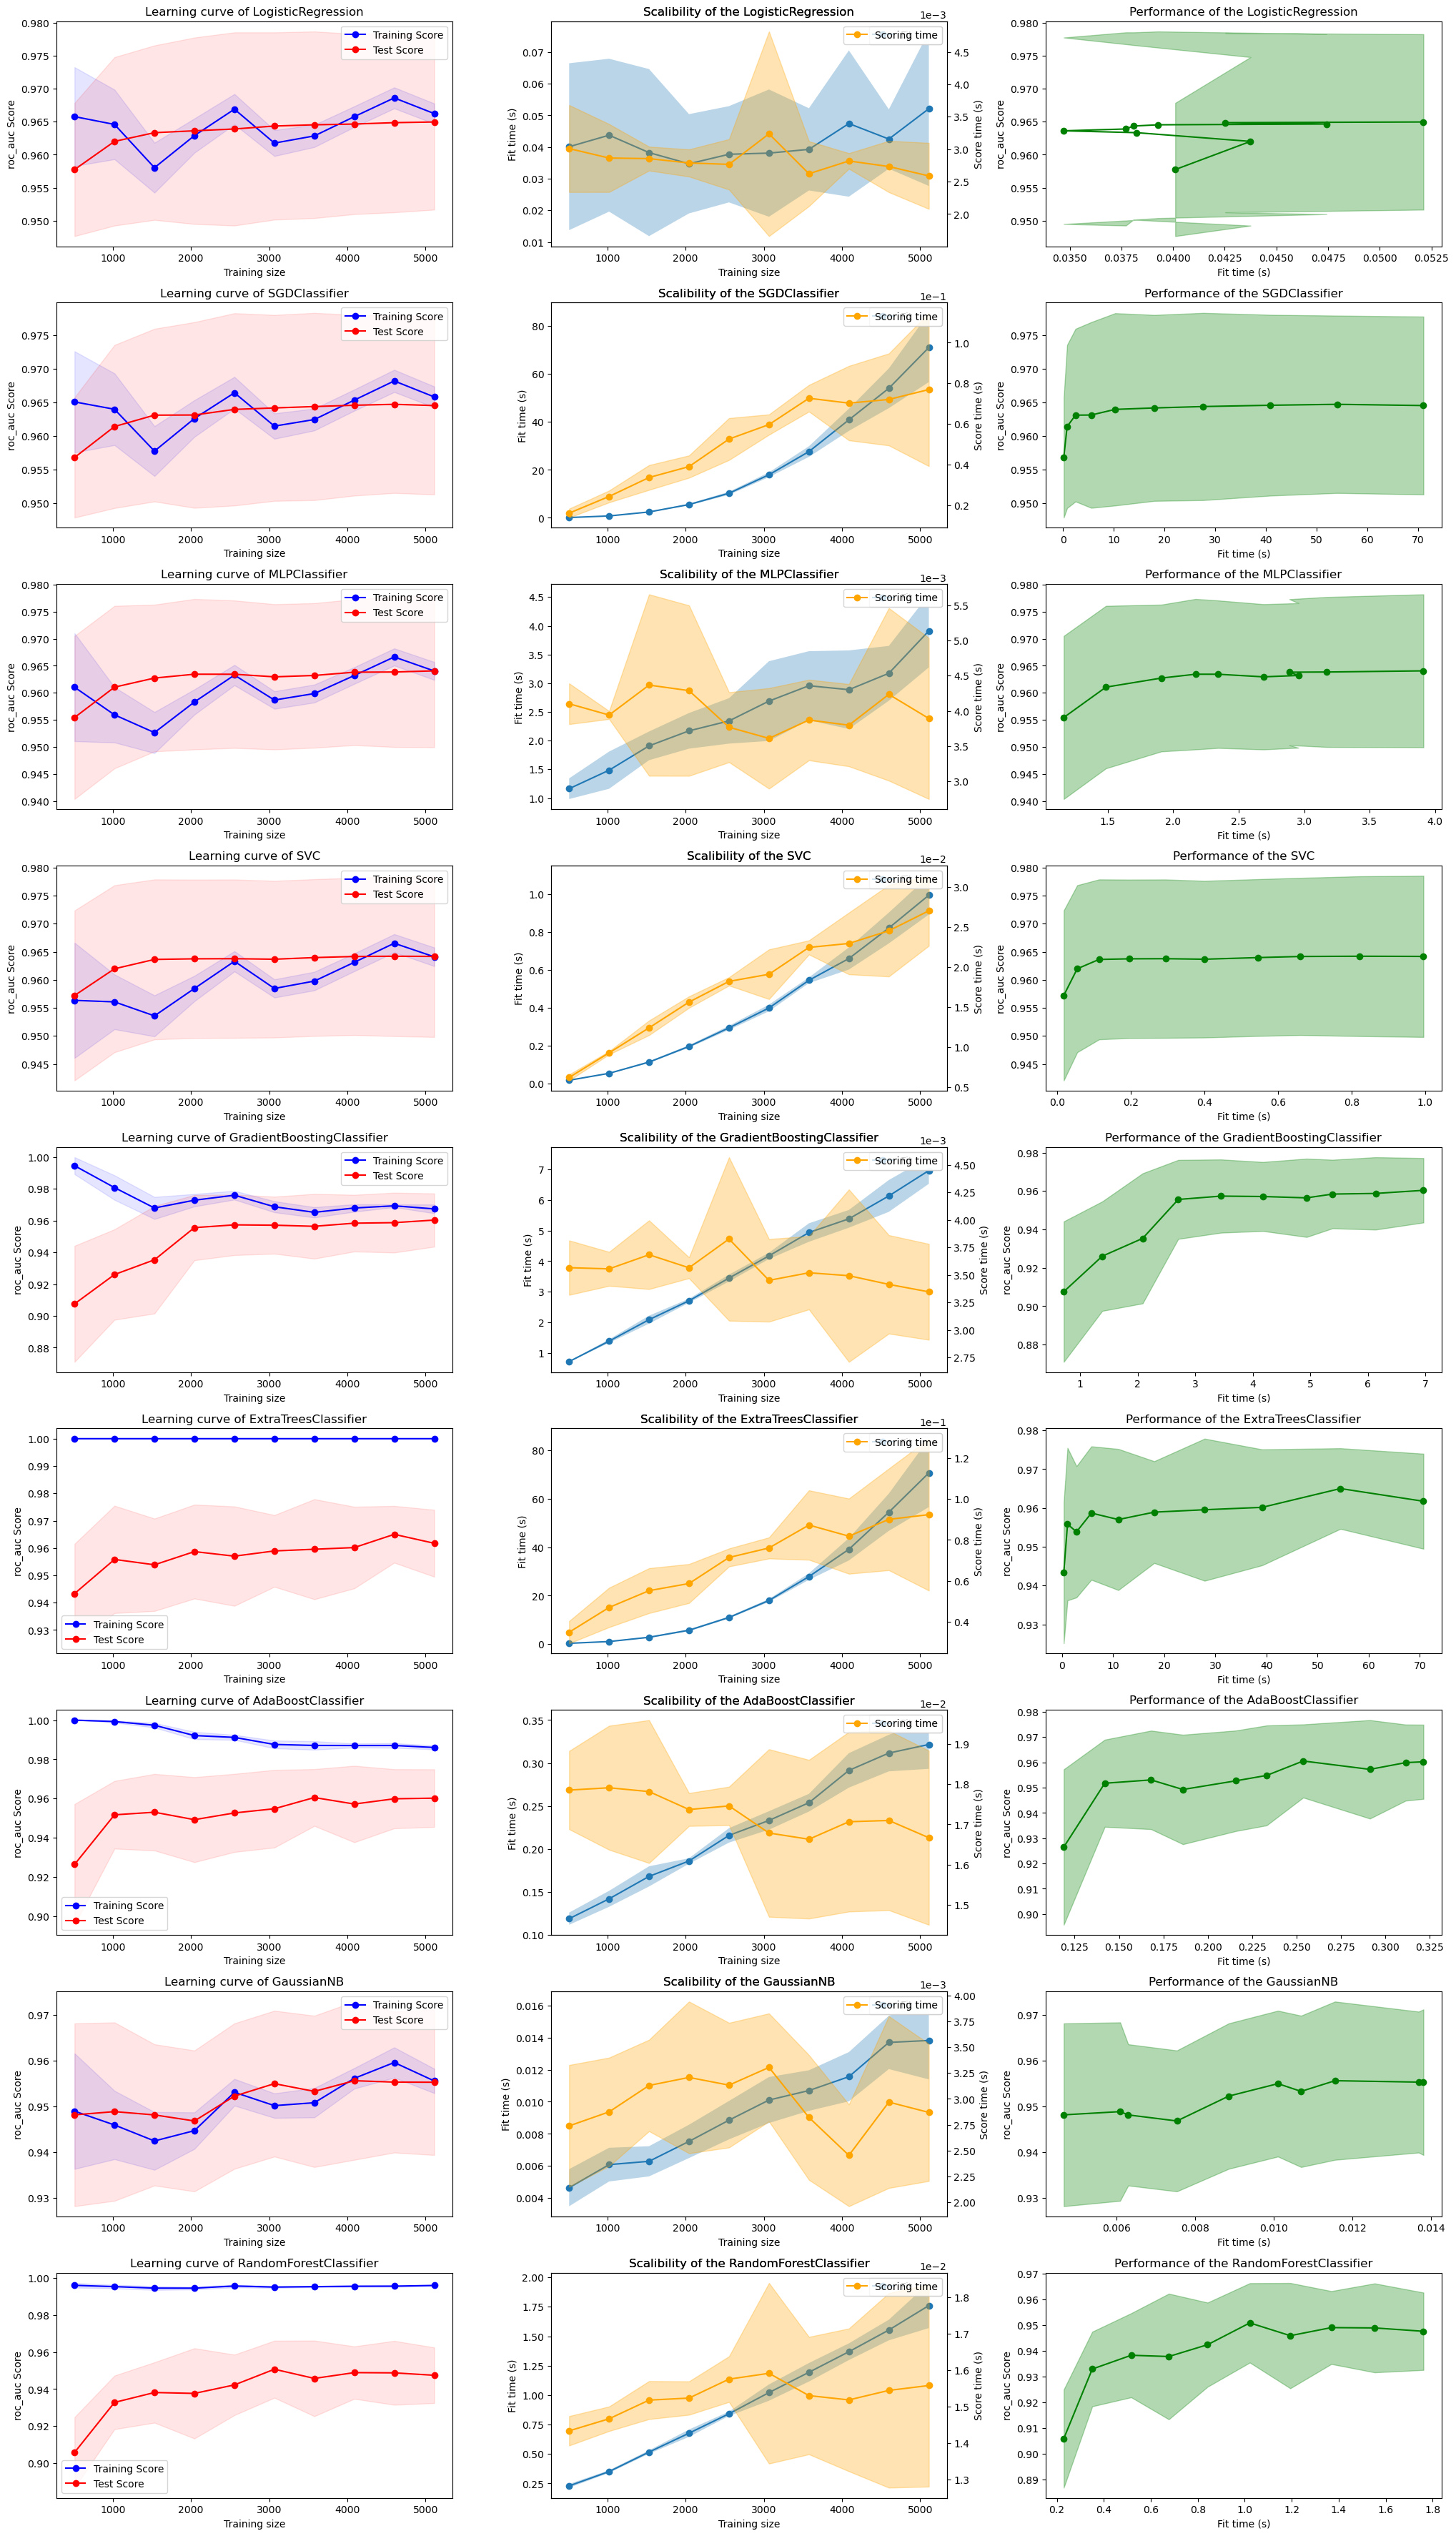

In [32]:
n_splits = 10
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": stratified_kf,
    "n_jobs": -1,
    #"line_kw": {"marker": "o"},
    #"std_display_style": "fill_between",
    "scoring": "roc_auc",
    'return_times': True, 
}

class_names = ['LOS', 'NLOS']


fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=3, figsize=(25, 45))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
# Learning curve for top 5 pipelines
    est_name = pipeline.named_steps['estimator'].__class__.__name__
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(pipeline, **common_params, verbose = 0)
    
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    # Plot training and test scores
    ax[ax_idx][0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
    ax[ax_idx][0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ax[ax_idx][0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training Score")
    ax[ax_idx][0].plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test Score")
    ax[ax_idx][0].legend(loc="best")
    
    
    ax[ax_idx][0].set_title(f'Learning curve of {est_name}')
    ax[ax_idx][0].set_xlabel("Training size")
    ax[ax_idx][0].set_ylabel(f"{common_params['scoring']} Score")

#Validation curve for top pipelines
# scalability regarding the fit time
    ax[ax_idx][1].plot(train_sizes, fit_times.mean(axis=1), "o-", label="Fit time")
    ax[ax_idx][1].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx][1].set_xlabel("Training size")
    ax[ax_idx][1].set_ylabel("Fit time (s)")
    ax[ax_idx][1].set_title(f'Scalibility of the {est_name}')
    ax[ax_idx][1].legend(loc="best")

# scalability regarding the score time
    axx = ax[ax_idx][1].twinx()
    axx.plot(train_sizes, score_times.mean(axis=1), "o-", color = 'orange', label="Scoring time")
    axx.fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3, color = 'orange'
    )
    axx.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 
    axx.set_xlabel("Training size")
    axx.set_ylabel("Score time (s)")
    axx.set_title(f'Scalibility of the {est_name}')
    axx.legend(loc="best")

# Pipeline performance based to test score 
    ax[ax_idx][2].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-", color="g")
    ax[ax_idx][2].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3, color="g"
    )
    ax[ax_idx][2].set_ylabel(f"{common_params['scoring']} Score")
    ax[ax_idx][2].set_xlabel("Fit time (s)")
    ax[ax_idx][2].set_title(
        f"Performance of the {est_name}"
    )
#LearningCurveDisplay.from_estimator(pipeline, **common_params, ax=ax[ax_idx, 0])
#handles, label = ax[ax_idx, 0].get_legend_handles_labels()
#ax[ax_idx][0].legend(handles[:2], ["Training Score", "Test Score"])
#est_name = pipeline.named_steps['estimator'].__class__.__name__
#ax[ax_idx][0].set_title(est_name)



### Find the optimum Threshold based on 10-fold cross validatio and visualizing ROC curve and confusion matrix

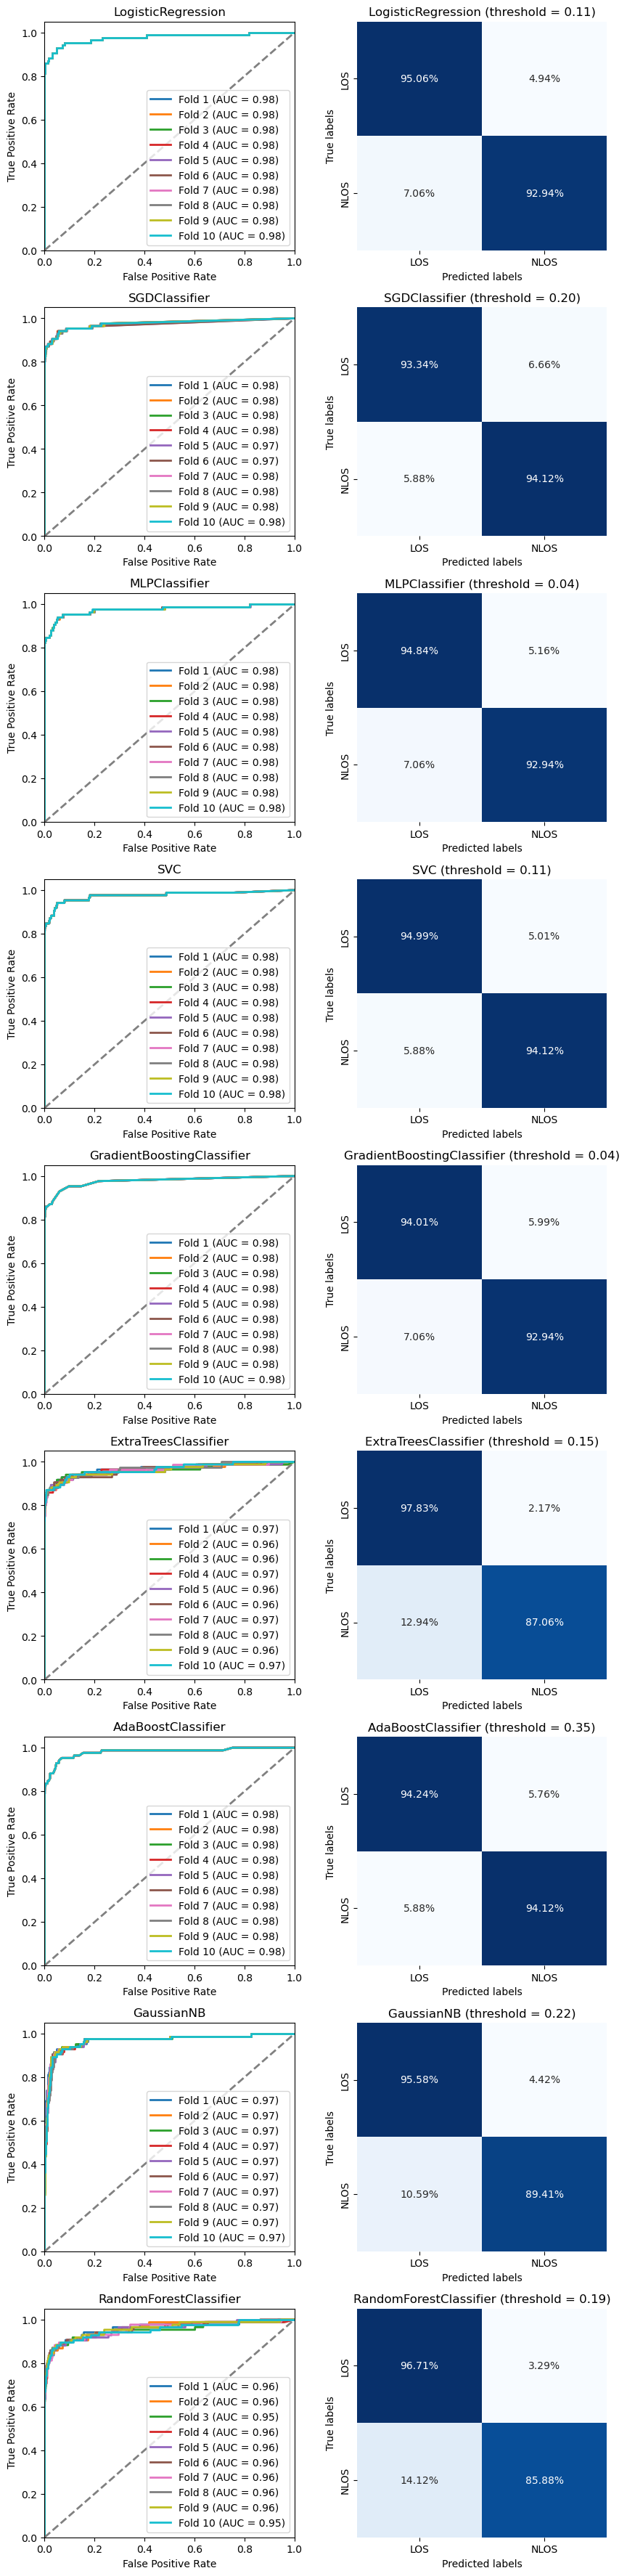

In [33]:
fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=2, figsize=(10, 45))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
#ROC curve for top 5 pipelines
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_threshold = []
    # Create an instance of StratifiedKFold with 10 folds
    n_splits = 10
    for fold, (train_index, test_index) in enumerate(stratified_kf.split(X_train, y_train)):
        XX_train, XX_test = XX[train_index], XX[test_index]
        yy_train, yy_test = labels[train_index], labels[test_index]
    
    # Fit the pipeline on the training data for the current fold
        pipeline.fit(X_train, y_train)
    
    # Get the predicted probabilities for the positive class
        y_prob = pipeline.predict_proba(X_test)
    
    # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)

        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]
    # Calculate AUC
        roc_auc_fold = auc(fpr, tpr)

    # Store ROC data for this fold
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_auc.append(roc_auc_fold)
        all_threshold.append(optimal_threshold)
        est_name = pipeline.named_steps['estimator'].__class__.__name__

    # Plot the ROC curves for each fold
    for fold in range(n_splits):
        ax[ax_idx][0].plot(all_fpr[fold], all_tpr[fold], lw=2, label=f'Fold {fold+1} (AUC = {all_auc[fold]:.2f})')

    ax[ax_idx][0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax[ax_idx][0].set_xlim([0.0, 1.0])
    ax[ax_idx][0].set_ylim([0.0, 1.05])
    ax[ax_idx][0].set_xlabel('False Positive Rate')
    ax[ax_idx][0].set_ylabel('True Positive Rate')
    ax[ax_idx][0].set_title(f'{est_name}')
    ax[ax_idx][0].legend(loc='lower right')

#COnfusion matrix based based on optimal threshold
    custom_threshold = np.mean(all_threshold)
    y_pred = (y_prob[:, 1] >= custom_threshold).astype(int)  # Assuming binary classification
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[ax_idx, 1])
    ax[ax_idx, 1].set_xlabel("Predicted labels")
    ax[ax_idx, 1].set_ylabel("True labels")
    ax[ax_idx, 1].set_title(f'{est_name} (threshold = {custom_threshold:.2f})')
    

### Testing Voting and Stacking classification performance

Accuracy of the VotingClassifier Classifier: 0.9549612948627727
Accuracy of the StackingClassifier Classifier: 0.9542575650950035


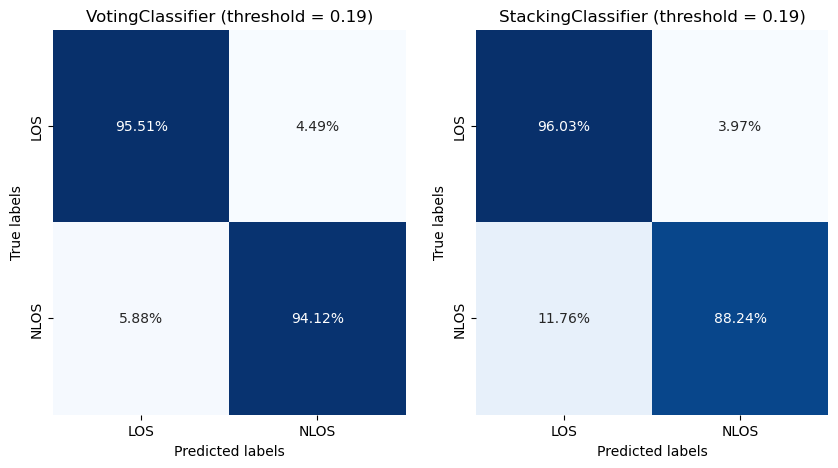

In [54]:
estimators = [('pipe' + str(i+1), top_pipelines[i]) for i in range(9)]
integrated_classifier = [VotingClassifier(estimators= estimators, voting='soft'),
                         StackingClassifier(estimators=estimators[:], final_estimator=AdaBoostClassifier())]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))    
for ax_idx, estimator in enumerate(integrated_classifier): 
    estimator.fit(X_train, y_train)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the {estimator.__class__.__name__} Classifier:", accuracy)

    y_prob = estimator.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)  # Assuming binary classification
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[ax_idx])
    ax[ax_idx].set_xlabel("Predicted labels")
    ax[ax_idx].set_ylabel("True labels")
    ax[ax_idx].set_title(f'{estimator.__class__.__name__} (threshold = {custom_threshold:.2f})')

FINISHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH ---> NEW codes for novel ideas will be added after this breakpoint reminder 